# AML Project
- Shivangi Gupta
- Satvik Shankar
- Nandini Anand Kumar
- Katelyn Coldicott

## Trend Classification and Drift Detection in Short-Form Videos

## 2. EDA

### 2.1 Data Overview & Missing Values

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (10, 5)

# if already loaded, skip this
df = pd.read_csv("/Users/shivi/Downloads/Fall/1) Advanced ML/Project/youtube_tiktok_trends_2025_preprocessed.csv")

df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400094 entries, 0 to 1400093
Data columns (total 76 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   trend_label                   1400094 non-null  object 
 1   platform_x                    1400094 non-null  object 
 2   creator_tier                  1400094 non-null  object 
 3   title_len                     1400094 non-null  float64
 4   text_richness                 1400094 non-null  float64
 5   like_rate                     1400094 non-null  float64
 6   comment_rate                  1400094 non-null  float64
 7   share_rate                    1400094 non-null  float64
 8   like_rate_log                 1400094 non-null  float64
 9   comment_rate_log              1400094 non-null  float64
 10  share_rate_log                1400094 non-null  float64
 11  views_per_day                 1400094 non-null  float64
 12  likes_per_day               

In [5]:
# Count and percentage of missing values per column
missing_counts = df.isnull().sum().sort_values(ascending=False)
missing_pct = (missing_counts / len(df)).sort_values(ascending=False)

missing_summary = pd.DataFrame({
    'missing_count': missing_counts,
    'missing_pct': missing_pct
})

missing_summary.head(20)


,missing_count,missing_pct
avg_er,0,0.0
avg_velocity_y,0,0.0
category_Comedy,0,0.0
category_Education,0,0.0
category_Food,0,0.0
category_Gaming,0,0.0
category_Lifestyle,0,0.0
category_Music,0,0.0
category_News,0,0.0
category_Sports,0,0.0


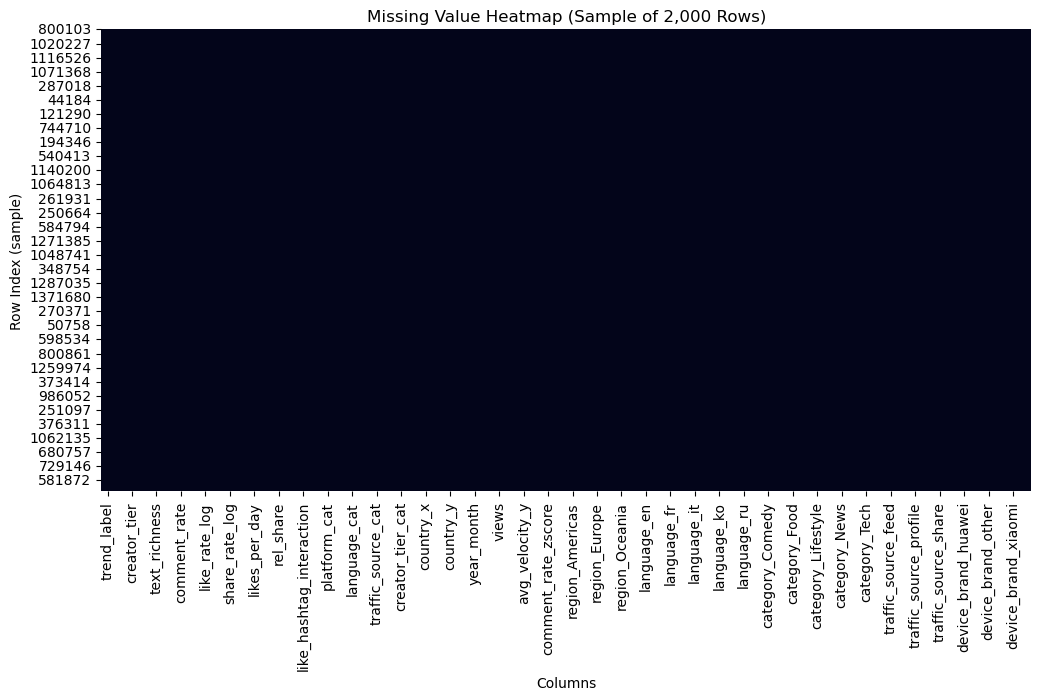

In [7]:
sample_df = df.sample(n=2000, random_state=42)

plt.figure(figsize=(12, 6))
sns.heatmap(sample_df.isnull(), cbar=False)
plt.title("Missing Value Heatmap (Sample of 2,000 Rows)")
plt.xlabel("Columns")
plt.ylabel("Row Index (sample)")
plt.show()

Since data preprocessing was already completed, the dataset we analyze in this section is fully cleaned, merged across all supporting files, encoded, and formatted for modeling. The final integrated dataset contains approximately 1 million video-level observations with a mix of:

- Engagement metrics (views, likes, shares, engagement rate, velocity)

- Relative performance indicators (rel_like, rel_share, rel_combo)

- Categorical encodings (category_cat, language_cat, sound_type_cat, creator_tier_cat, traffic_source_cat)

- Region, device, and temporal features

- Text/interaction metrics such as text_richness and comment_rate

A complete missing-value audit shows that all variables have 0 missing values, confirming that the merged and preprocessed dataset is ready for analysis.
The heatmap appears as a solid dark block because df.isnull() returns all False values across ~1M rows, indicating no imputation is needed at this stage.

### 2.2 Target Variable Analysis

Goal of this section:

- Understand how rising / stable / declining videos are distributed.

- Decide whether we’ll need class weights / SMOTE later.

In [8]:
# Check basic info about the target
df['trend_label'].unique(), df['trend_label'].dtype


(array(['stable', 'rising', 'declining', 'seasonal'], dtype=object),
 dtype('O'))

#### Class Counts and Proportions

In [9]:
# Use the name column if you created it, otherwise trend_label
target_col = 'trend_label_name' if 'trend_label_name' in df.columns else 'trend_label'

class_counts = df[target_col].value_counts()
class_props  = df[target_col].value_counts(normalize=True)

print("Class counts:")
print(class_counts)
print("\nClass proportions:")
print(class_props)


Class counts:
trend_label
rising       837500
declining    530192
stable        27696
seasonal       4706
Name: count, dtype: int64

Class proportions:
trend_label
rising       0.598174
declining    0.378683
stable       0.019782
seasonal     0.003361
Name: proportion, dtype: float64


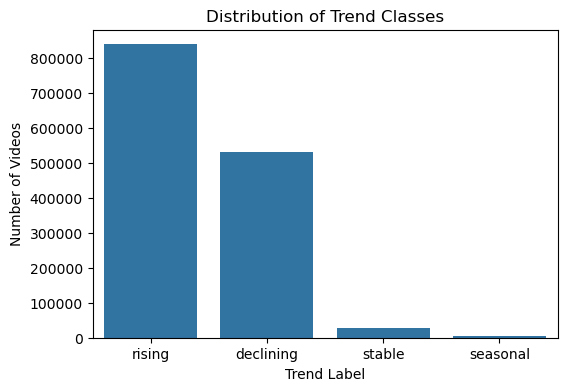

In [10]:
plt.figure(figsize=(6,4))
sns.countplot(x=target_col, data=df,
              order=class_counts.index)
plt.title("Distribution of Trend Classes")
plt.xlabel("Trend Label")
plt.ylabel("Number of Videos")
plt.show()


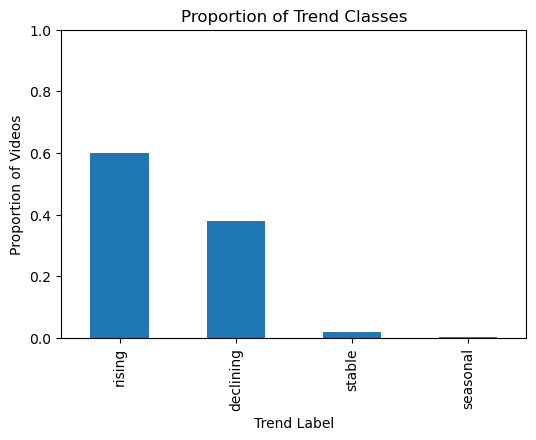

In [11]:
plt.figure(figsize=(6,4))
(class_props
 .reindex(class_counts.index)   # keep same order as counts
 .plot(kind='bar'))

plt.title("Proportion of Trend Classes")
plt.xlabel("Trend Label")
plt.ylabel("Proportion of Videos")
plt.ylim(0, 1)
plt.show()


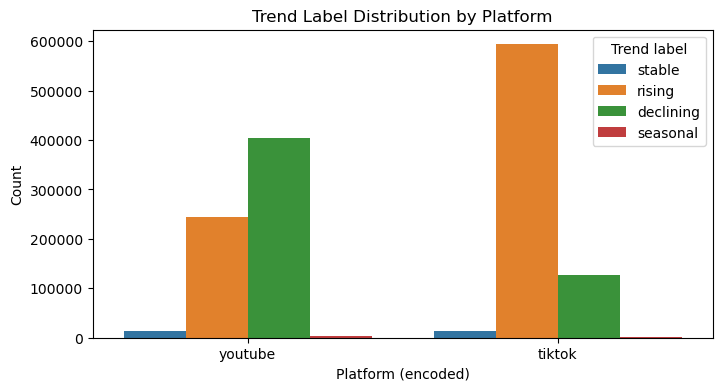

In [18]:
# Example: trend distribution by platform
if 'platform_cat' in df.columns:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x='platform_x', hue=target_col)
    plt.title("Trend Label Distribution by Platform")
    plt.xlabel("Platform (encoded)")
    plt.ylabel("Count")
    plt.legend(title="Trend label")
    plt.show()


The trend labels show a strongly polarized engagement pattern:

Rising ≈ 60%

Declining ≈ 38%

Stable ≈ 2%

Seasonal ≈ 0.2%

This indicates that short-form videos rarely maintain steady performance — they typically either gain momentum quickly or drop off quickly. Stable and seasonal patterns are almost nonexistent, highlighting the highly volatile nature of short-form engagement.

From a modeling perspective, this imbalance has three key implications:
- Risk of Majority-Class Bias:
Without correction, the model will overwhelmingly predict rising or declining and effectively ignore the stable and seasonal classes.

- Need for Balanced Evaluation:
Accuracy alone becomes misleading. Metrics like macro-F1 and per-class recall are necessary to ensure minority classes are not ignored.

- Importance of Class Handling:
Techniques such as class weights or minority oversampling (SMOTE) will be required to give stable/seasonal classes enough representation during training.

Platform-wise breakdown further shows that tiktok contributes more rising videos while the youtube contributes more declining ones, suggesting systematic platform-level engagement differences, making platform_cat a meaningful predictive feature.

Overall, the target distribution confirms that the model must learn to detect rapid engagement shifts, while explicitly accounting for the rare but strategically important stable and seasonal patterns.

### 2.3 Engagement Metrics Exploration

Short-form video engagement is naturally heavy-tailed: most videos receive modest traction, while a very small fraction achieve viral-level metrics. Understanding this distribution is essential for both feature engineering and model choice.

#### 2.3.1 DISTRIBUTIONS

In [27]:
eng_cols = [
    'views', 'views_per_day', 'likes_per_day',
    'like_rate', 'share_rate', 'comment_rate',
    'like_rate_log', 'share_rate_log', 'comment_rate_log',
    'like_rate_zscore', 'share_rate_zscore', 'comment_rate_zscore',
    'avg_er', 'avg_velocity_y',
    'rel_like', 'rel_share', 'rel_combo',
    'like_hashtag_interaction', 'share_hashtag_interaction',
    'richness_traffic_interaction'
]

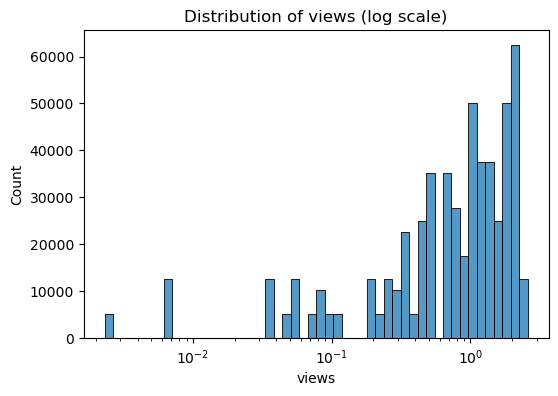

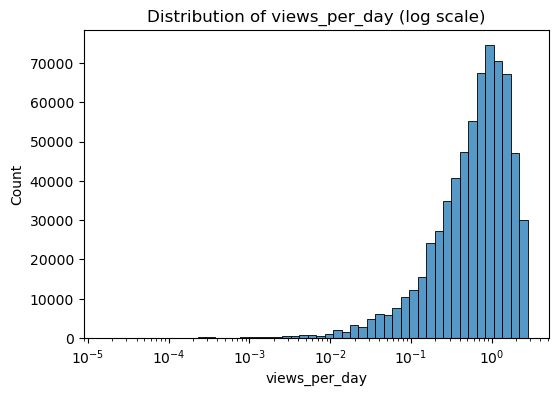

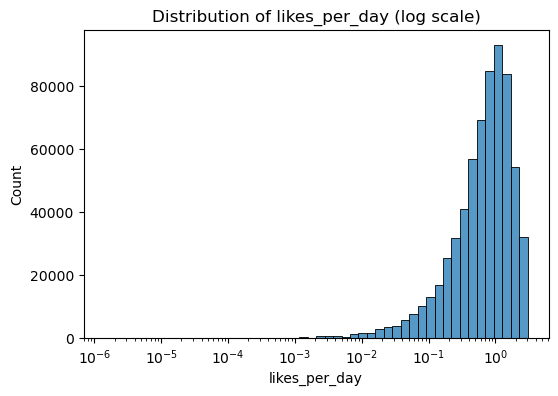

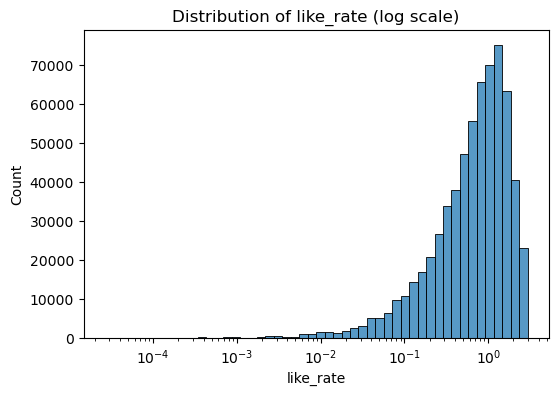

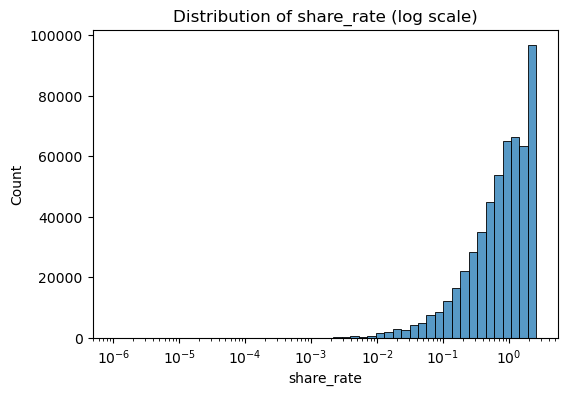

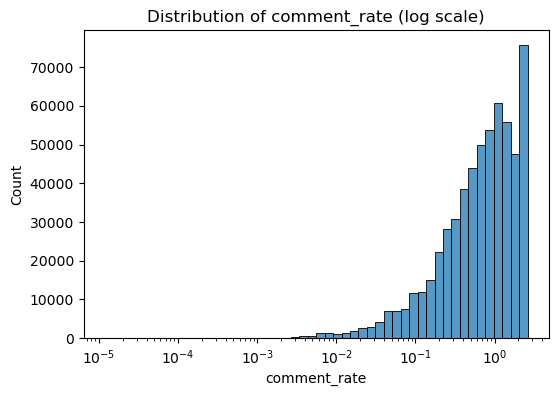

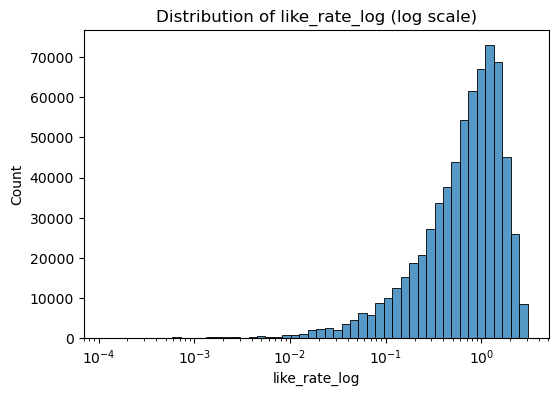

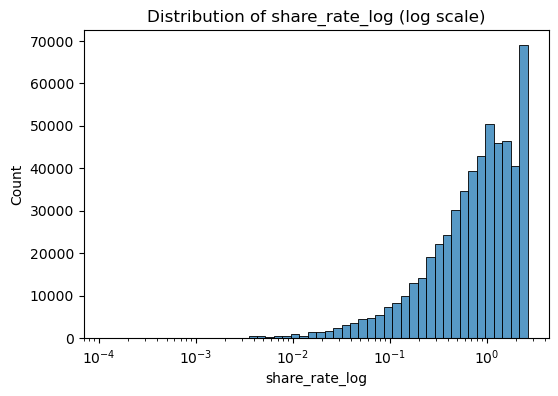

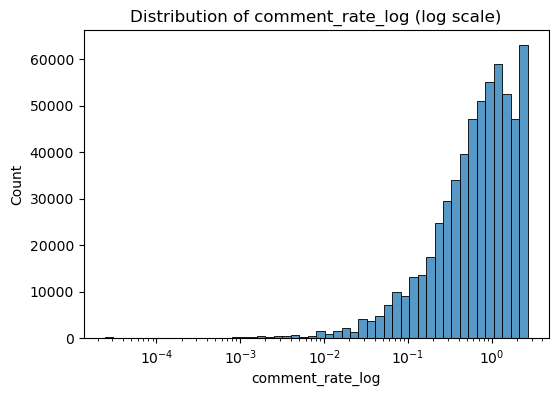

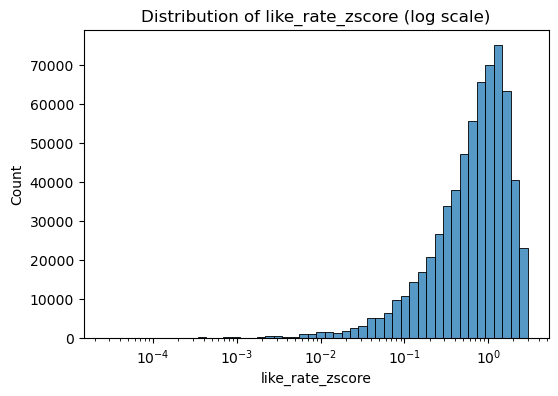

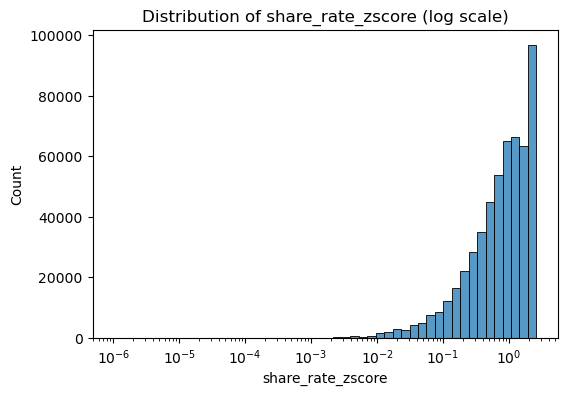

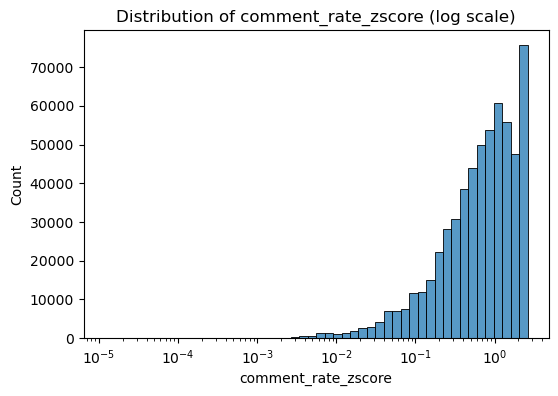

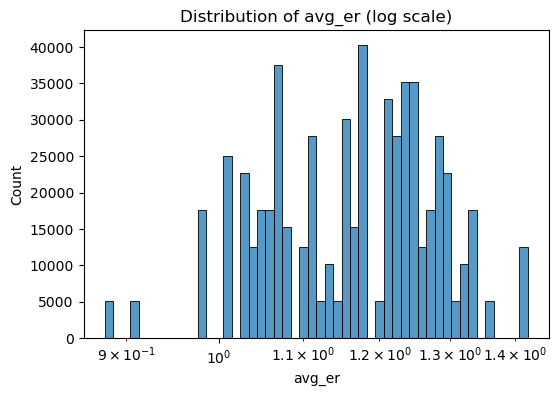

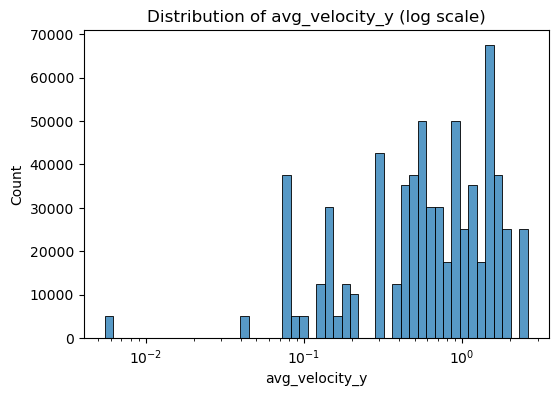

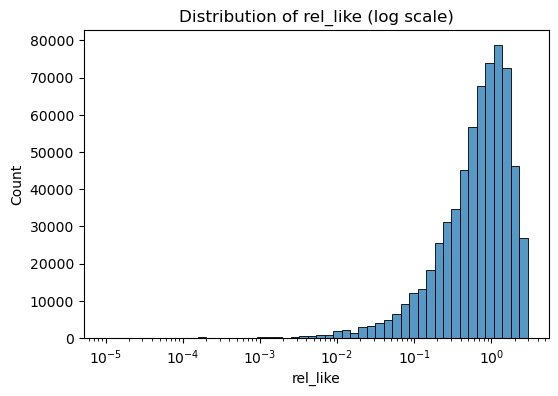

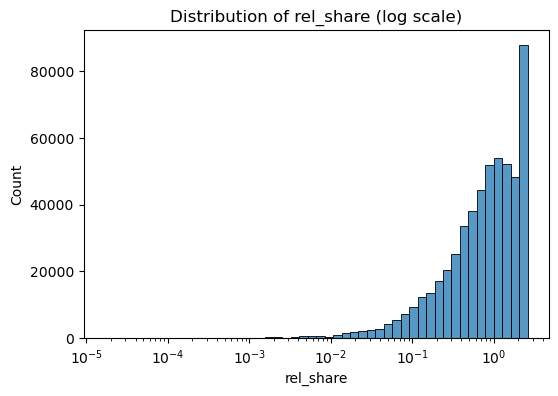

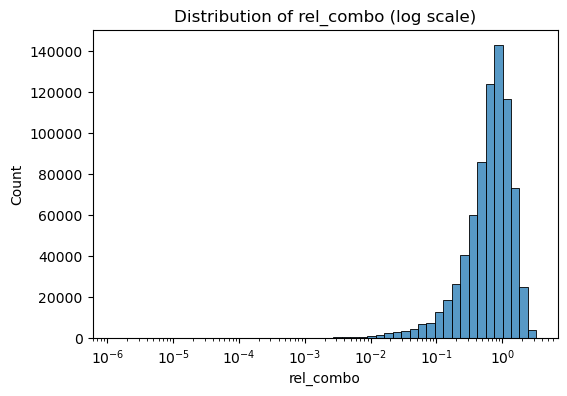

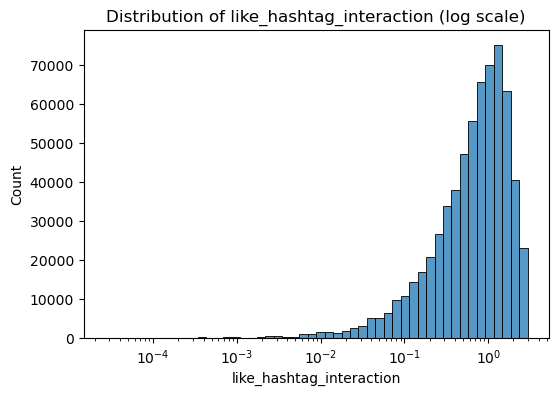

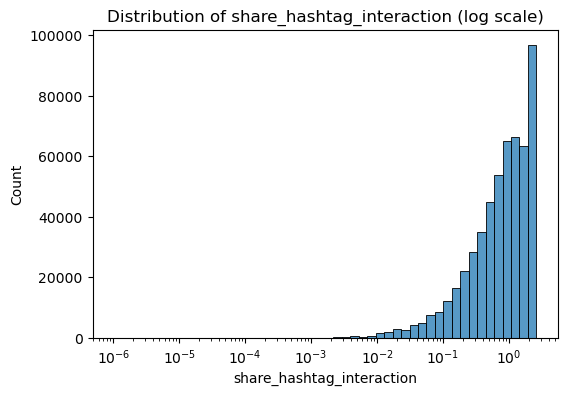

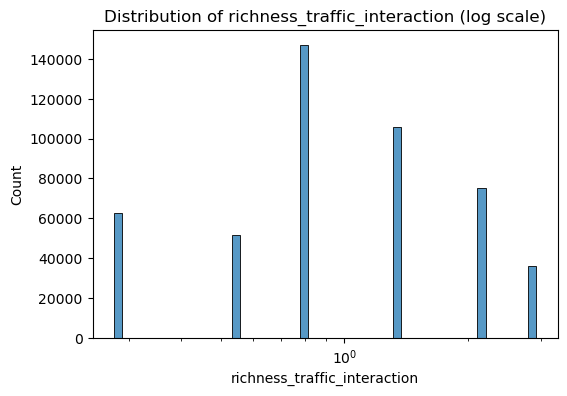

In [28]:
for col in eng_cols:
    if col in df.columns:
        plt.figure(figsize=(6,4))
        sns.histplot(df[col], bins=50, log_scale=True)
        plt.title(f"Distribution of {col} (log scale)")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.show()
    else:
        print(f"Skipping {col}, not found in dataset.")


The engagement features in this dataset represent multiple dimensions of video performance — raw interactions (views, likes_per_day), normalized rates (like_rate, share_rate), statistical transforms (log and z-scores), and platform-relative metrics (rel_like, rel_share, rel_combo).

Across all these variables, the distributions are consistently heavy-tailed, even under log-scaling. This confirms a core property of short-form video behavior:

Most videos generate low to moderate engagement, while a small minority achieve disproportionately high performance — the signature of viral content.

Key insights:
1. Normalized metrics (rates, logs, z-scores) reduce extreme skew

    - like_rate_log, share_rate_log, and their z-scored counterparts show tighter distributions.

    - These features provide more stable modeling signals compared to raw counts.

2. Relative engagement metrics (rel_like, rel_share, rel_combo) are the cleanest indicators

    These adjust engagement relative to platform/community baselines.
    Their smoother distributions make them especially suited for trend classification.

4. Viral videos remain extreme outliers

Even after log scaling, views and views_per_day show long right tails, implying:

    - Linear models need transformation

    - Tree-based models (RF, XGBoost, LightGBM) can naturally handle this variability

4. Interaction features capture meaningful nonlinear effects

Variables like like_hashtag_interaction and richness_traffic_interaction show dispersed distributions, suggesting different types of content benefit differently from hashtags or traffic sources.
These interactions may enhance non-linear modeling.

#### 2.3.2 CORRELATION ANALYSIS

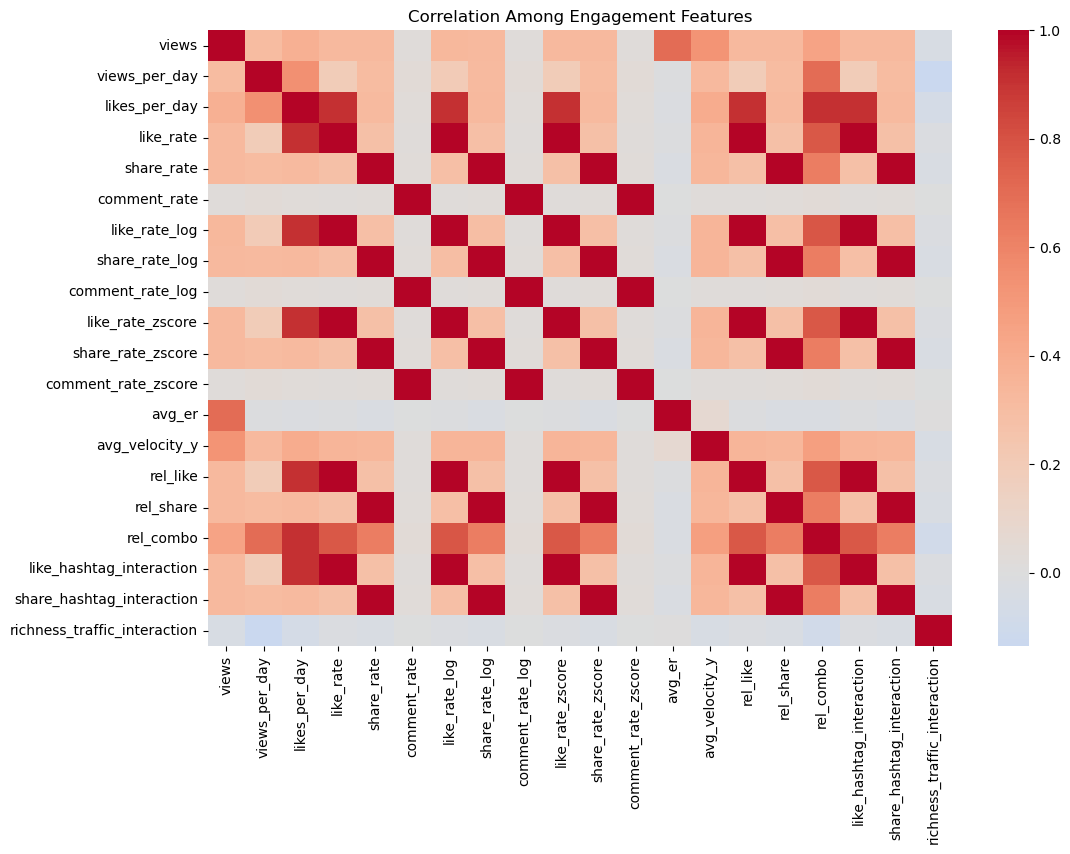

In [34]:
corr_eng = df[eng_cols].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_eng, annot=False, cmap='coolwarm', center=0)
plt.title("Correlation Among Engagement Features")
plt.show()


Correlation analysis reveals the internal structure of engagement behavior:

Strong positive correlations appear among rate-based and log-transformed features
(e.g., like_rate, share_rate, comment_rate, and their logs/z-scores).
This indicates that videos with strong performance in one interaction dimension typically perform well in others.

Raw interactions (views, likes_per_day) show weaker correlation with normalized metrics because raw counts are heavily influenced by creator size, platform differences, and recency.

Relative metrics (rel_like, rel_share, rel_combo) show moderate correlations with rate-based metrics but remain sufficiently distinct to add predictive value. These features appear to capture platform-level deviation effects rather than raw engagement volume.

Interaction-based metrics (e.g., like_hashtag_interaction) show low-to-moderate correlations with other features, suggesting they capture nonlinear content-behavior effects that are orthogonal to simple counts or rates.

Overall, correlation patterns confirm that the feature set contains both redundant and complementary signals, and tree-based models will benefit from these hierarchical relationships.

#### 2.3.3 OUTLIERS

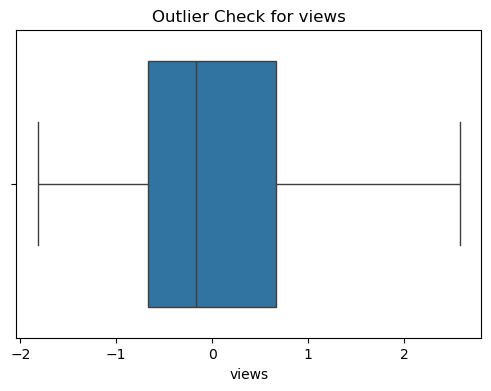

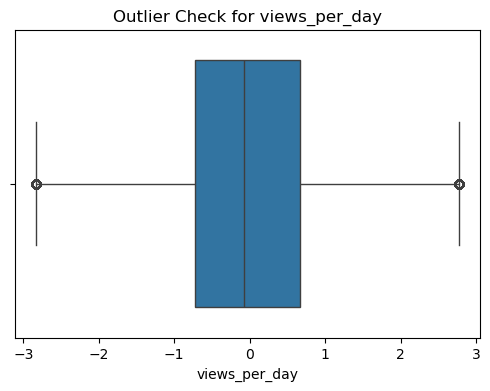

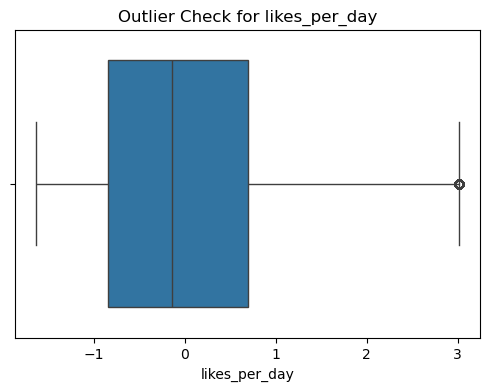

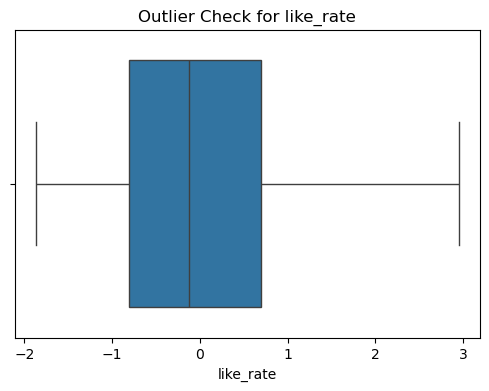

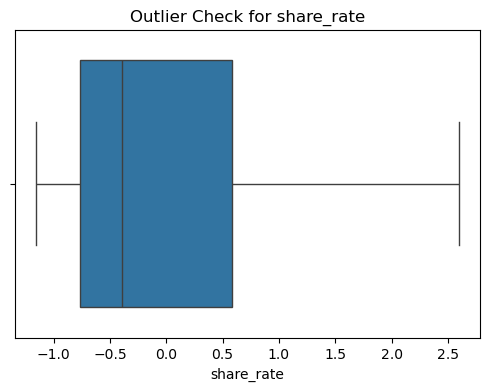

In [32]:
for col in ['views', 'views_per_day', 'likes_per_day', 'like_rate', 'share_rate']:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col])
    plt.title(f"Outlier Check for {col}")
    plt.show()


Engagement metrics exhibit extreme outliers, especially in views, views_per_day, and rate-based metrics. This behavior is fully expected in short-form video platforms, where a small fraction of content achieves disproportionately high reach (viral content).

Key insights:

1. Outliers are not noise — they represent genuine viral behavior and must be retained, not clipped.

2. Log transformations significantly reduce the visual dominance of these extreme values, making patterns more interpretable.

3. Because of the long-tailed distributions, robust models (tree-based boosting) naturally handle these outliers better than linear models.

4. Rate-based and relative metrics show fewer extreme outliers, confirming they are more stable and ideal for trend classification.

### 2.4 Relationship between Engagement Metrics and Trend Labels

Goal is to understand how rising, declining, stable, and seasonal videos differ in their engagement metrics, and identify which features are most discriminative for modeling.

We will examine the high-value metrics for trend separation:

- rel_like, rel_share, rel_combo

- views_per_day

- likes_per_day

- like_rate, share_rate, comment_rate

- avg_er

- avg_velocity_y

These metrics reflect platform-relative engagement, velocity (speed of growth), and normalized rates — all key indicators of whether a video is rising or declining.

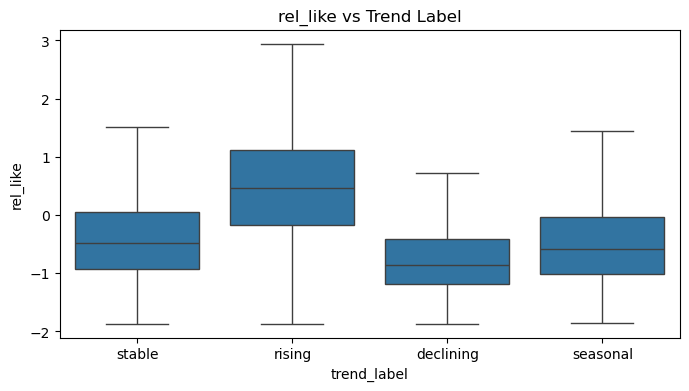

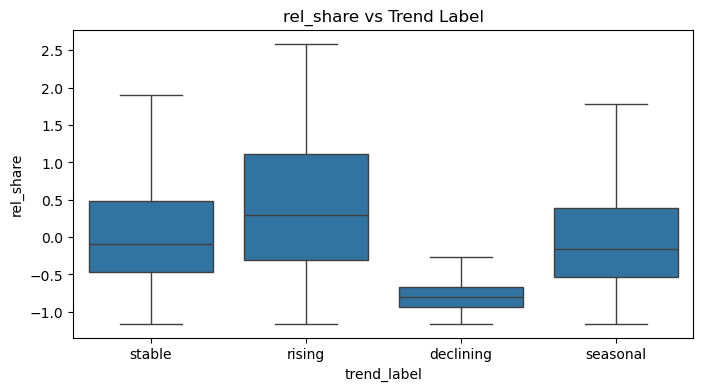

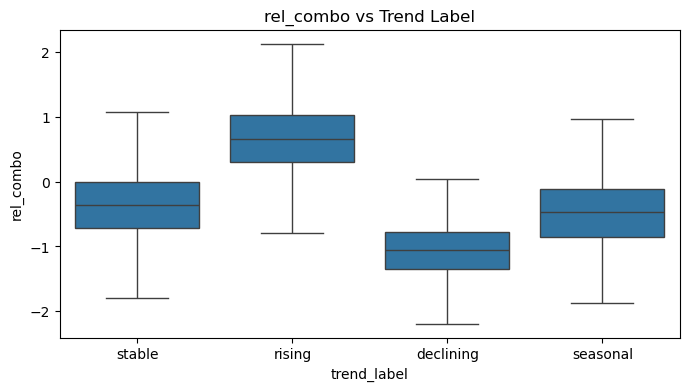

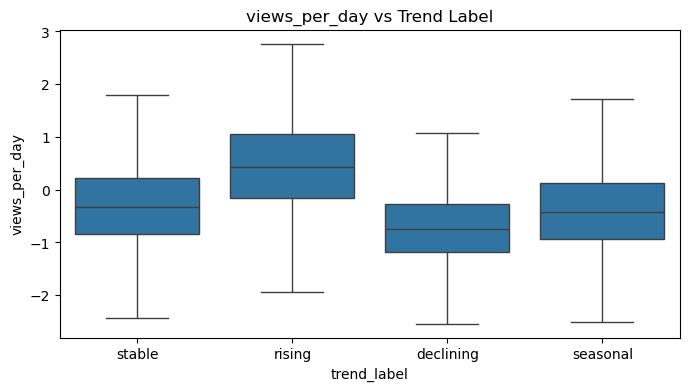

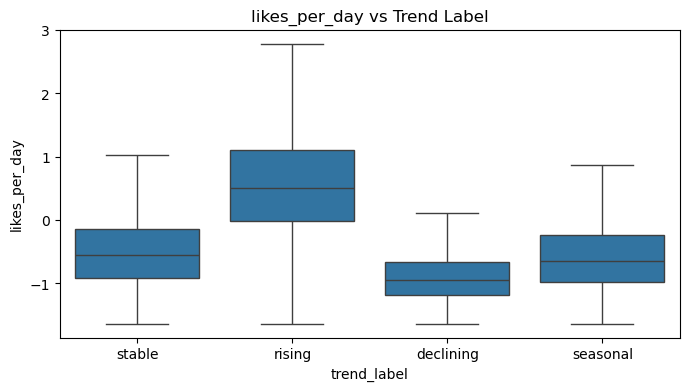

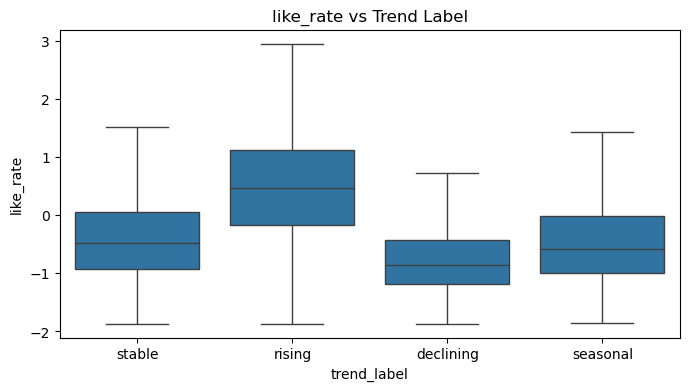

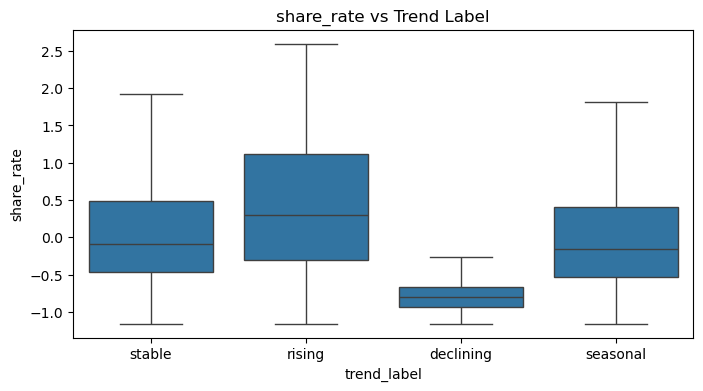

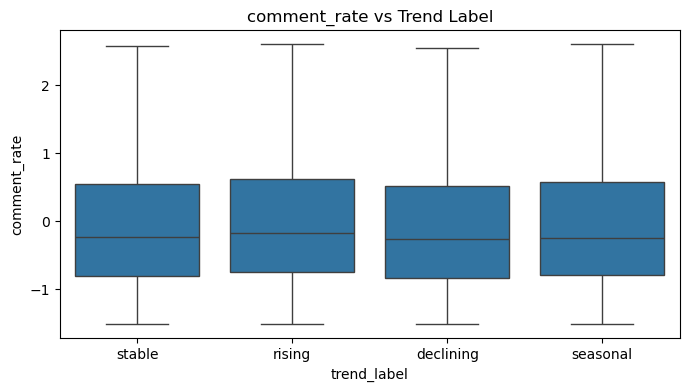

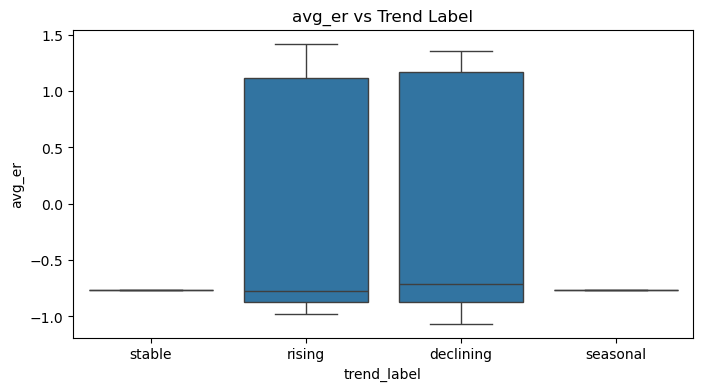

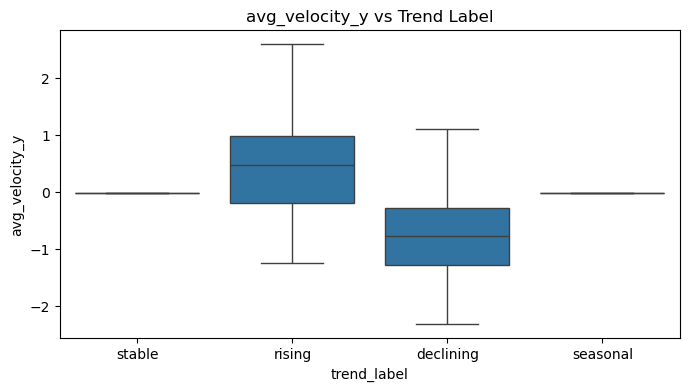

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

metrics_to_plot = [
    'rel_like', 'rel_share', 'rel_combo',
    'views_per_day', 'likes_per_day',
    'like_rate', 'share_rate', 'comment_rate',
    'avg_er', 'avg_velocity_y'
]

target = 'trend_label'  # if you mapped names earlier, use trend_label_name

for col in metrics_to_plot:
    if col in df.columns:
        plt.figure(figsize=(8,4))
        sns.boxplot(data=df, x=target, y=col, showfliers=False)
        plt.title(f"{col} vs Trend Label")
        plt.show()
    else:
        print(f"Skipping {col}, not found.")


The engagement patterns across trend labels show clear and consistent separation, revealing which metrics truly drive trend dynamics on short-form video platforms.

1. Relative engagement metrics are the strongest predictors

    rel_like, rel_share, and rel_combo show a striking monotonic pattern:
    rising > declining > stable/seasonal in both median values and spread.
    This confirms that performance relative to platform norms is the clearest indicator of whether a video is gaining or losing momentum.

2. Velocity cleanly distinguishes rising from declining

    avg_velocity_y highlights a sharp contrast:

    Rising videos accumulate engagement rapidly (positive velocity)

    Declining videos slow down or stall (negative/near-zero velocity)
    Velocity behaves like a “momentum signal” and is a top feature for trend prediction.

3. Per-day metrics capture growth intensity

    views_per_day and likes_per_day show significantly higher values for rising content, moderate values for declining, and consistently low levels for stable and seasonal videos.
    This reflects that trend classification is fundamentally about speed, not total volume.

4. Share rate is a powerful differentiator

    Among rate metrics, share_rate provides the cleanest class separation.
    Shares amplify reach more than likes or comments, explaining why rising videos have noticeably higher share activity.

5. Stable and seasonal classes lie consistently at the bottom

    These classes remain low across all engagement metrics, aligning with their small class proportions and confirming the need for class balancing during modeling.

Rising videos exhibit higher relative engagement, faster growth, and stronger sharing behavior, while declining videos show the opposite. Stable and seasonal content remain consistently low-performing.
Across all features, relative engagement (rel_*), velocity, and share rate emerge as the most discriminative signals for predicting trend direction.

### 2.5 Category and Language Effects

#### 2.5.1 By Category

In [47]:
category_cols = [col for col in df.columns if col.startswith("category_")]

category_trend = {}

for cat in category_cols:
    temp = df[df[cat] == True]['trend_label'].value_counts(normalize=True)
    category_trend[cat] = temp

category_trend_df = pd.DataFrame(category_trend).T.fillna(0)
category_trend_df


trend_label,declining,rising,seasonal,stable
category_cat,0.000000,0.000000,0.000000,0.000000
category_Comedy,0.385334,0.590831,0.003052,0.020783
category_Education,0.421169,0.556730,0.002700,0.019401
category_Food,0.417390,0.559814,0.002882,0.019914
category_Gaming,0.292022,0.684598,0.004827,0.018553
category_Lifestyle,0.352537,0.624292,0.004184,0.018988
category_Music,0.361118,0.610082,0.003807,0.024993
category_News,0.416206,0.559155,0.003083,0.021555
category_Sports,0.285358,0.697419,0.004029,0.013193
category_Tech,0.401205,0.575198,0.002798,0.020799


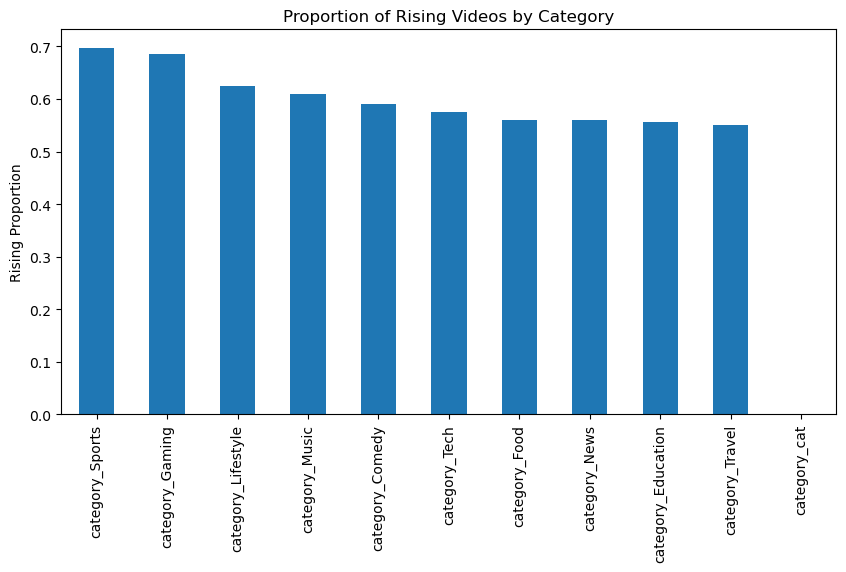

In [48]:
plt.figure(figsize=(10,5))
category_trend_df['rising'].sort_values(ascending=False).plot(kind='bar')
plt.title("Proportion of Rising Videos by Category")
plt.ylabel("Rising Proportion")
plt.show()


The category-level trend proportions show clear differences in how various content types perform on short-form platforms. Sports and Gaming have the highest share of rising videos (≈0.70 and ≈0.68), indicating that dynamic, fast-paced, and visually engaging content consistently drives stronger upward momentum. Lifestyle and Music also maintain high rising proportions (≈0.62 and ≈0.60), reflecting broad audience appeal and strong compatibility with trending sounds and formats.

Categories such as Comedy, Tech, Food, News, and Education show lower rising proportions (≈0.55–0.57). These categories still produce rising content, but at lower rates, likely due to more niche audiences, less share-driven dynamics, or slower engagement accumulation.

Overall, the results highlight that entertainment-driven, action-oriented, and visually stimulating categories (Sports, Gaming, Lifestyle, Music) are structurally more likely to rise, while informational or narrative-heavy categories tend to exhibit slower or more stable engagement patterns.

#### 2.5.2 By Language

In [49]:
language_cols = [col for col in df.columns if col.startswith("language_")]

language_trend = {}

for lang in language_cols:
    temp = df[df[lang] == True]['trend_label'].value_counts(normalize=True)
    language_trend[lang] = temp

language_trend_df = pd.DataFrame(language_trend).T.fillna(0)
language_trend_df


trend_label,declining,rising,seasonal,stable
language_cat,0.000000,0.000000,0.000000,0.000000
language_de,0.388152,0.589692,0.003203,0.018954
language_en,0.369806,0.607046,0.003348,0.019801
language_es,0.396749,0.581796,0.003122,0.018333
language_fr,0.384805,0.592706,0.002989,0.019501
language_hi,0.373762,0.603640,0.003315,0.019283
language_it,0.391140,0.585902,0.003415,0.019543
language_ja,0.390218,0.587113,0.003285,0.019384
language_ko,0.342693,0.630630,0.004162,0.022514
language_pt,0.396486,0.581030,0.003296,0.019188


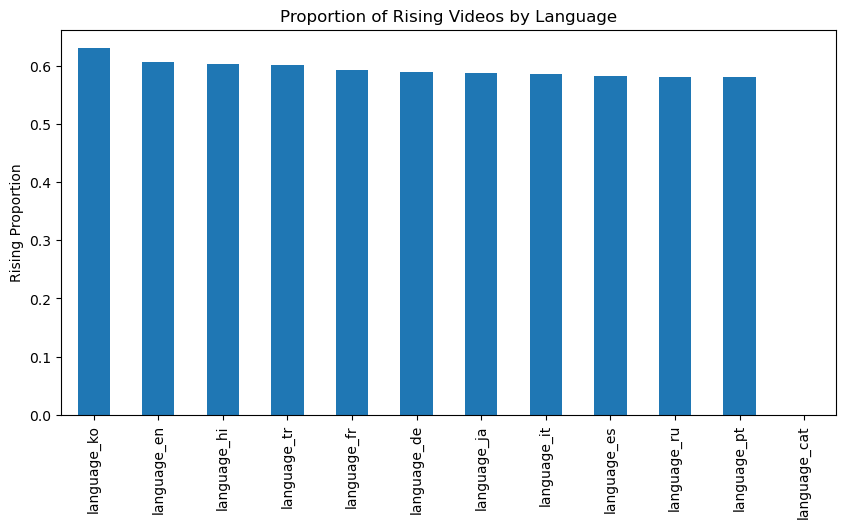

In [50]:
plt.figure(figsize=(10,5))
language_trend_df['rising'].sort_values(ascending=False).plot(kind='bar')
plt.title("Proportion of Rising Videos by Language")
plt.ylabel("Rising Proportion")
plt.show()


Rising proportions are relatively similar across languages (≈0.58–0.62), but clear patterns emerge:

1. Korean, English, and Hindi perform best

    These languages show the highest rising share (~0.60+), reflecting large, trend-active creator communities and strong alignment with global meme/music culture.

2. Spanish, Portuguese, and French follow closely

    They maintain strong rising proportions (~0.58–0.59), indicating broad reach but slightly more localized viral cycles.

3. Japanese, Turkish, Italian, and German show modestly lower rise rates

    These languages have vibrant ecosystems but produce more culturally contained content, leading to fewer explosive viral jumps.

Overall Insight

All languages rise at similar rates, but globally dominant or trend-heavy languages show a measurable edge in producing upward-trajectory videos.

### 2.6 Temporal Patterns

Temporal dynamics play a central role in short-form video engagement. Videos rise or decline depending not just on content but when they are posted and how trends evolve month-to-month. We explore:

• Hour-of-day posting effects

• Monthly trend behavior using year_month

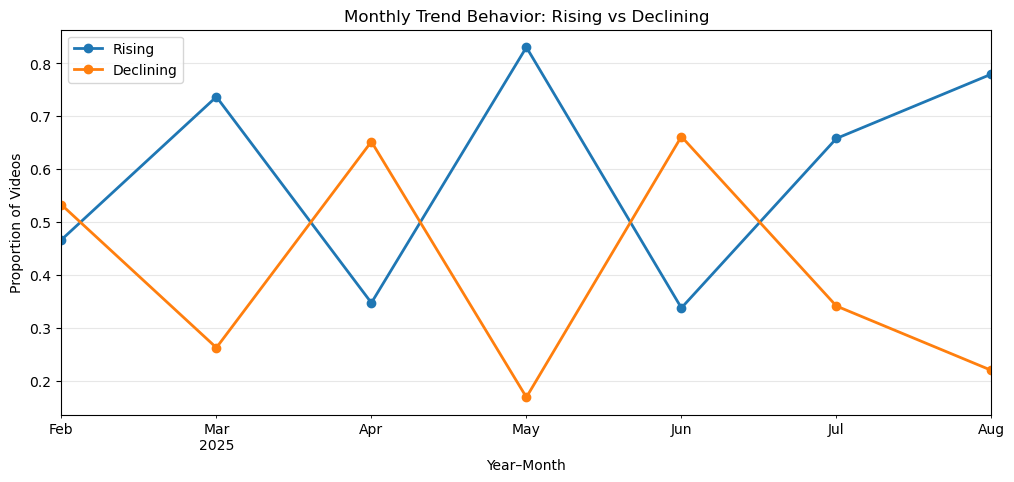

In [58]:
df_months = df[df['year_month'] != "Unknown"].copy()
df_months['year_month'] = pd.to_datetime(df_months['year_month'], format="%Y-%m")
df_months = df_months.sort_values('year_month')
month_trend = (
    df_months.groupby('year_month')['trend_label']
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
)
month_trend
plt.figure(figsize=(12,5))
month_trend['rising'].plot(marker='o', linewidth=2, label='Rising')
month_trend['declining'].plot(marker='o', linewidth=2, label='Declining')
plt.title("Monthly Trend Behavior: Rising vs Declining")
plt.xlabel("Year–Month")
plt.ylabel("Proportion of Videos")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


The monthly trend pattern shows clear cyclical swings between rising and declining videos:

- Rising content peaks in March, May, and August (≈0.74–0.83), indicating strong trend cycles or major platform events during these months that significantly boost upward momentum.

- Declining content peaks in February, April, and June (≈0.53–0.66), suggesting periods of saturation where fewer videos sustain engagement or break into upward trajectories.

Across the timeline, rising and declining proportions move inversely, implying strong platform-wide trend dynamics rather than random fluctuations.

Overall Insight:
The platform exhibits noticeable monthly engagement cycles, with certain months structurally favoring rising content. These temporal swings highlight the importance of including year_month (or seasonal features) in the modeling pipeline to capture underlying trend rhythms and platform seasonality.

### SUMMARY

EDA confirms that a combination of engagement intensity, content type, language ecosystem, platform characteristics, and temporal dynamics drives trend behavior. These findings guide feature engineering and model design by highlighting the most predictive information sources—particularly relative engagement metrics, velocity, category signals, and temporal seasonality.